# SITCOM-1120: Brake analysis

# Dates and time of the brake test
#### E-stop - rolex
 1.  2023-11-22T19:56:33.622523
 2.  2023-11-23T00:51:28
 3.  2023-11-23T02:32:17.254532
   * 2023-11-23 00:38 UTC - 2023-11-23 00:42 UTC
   * Az from 151º to 0º
   * We stopped around 102.5º, and we overshot until 89.67º
  4. 2023-11-23T03:08:50.50
   * 023-11-23 01:02 UTC - 2023-11-23 01:05 UTC
   * El from 20º to 80º.
   * We stopped around 40º, and we overshooted until 45º.
 5. 2023-11-23T03:10:09
     2023-11-23 01:35 UTC - 2023-11-23 01:40 UTC
   * Elevation from 80º to 20º.
   * We stopped around 57.8º, and we overshooted until 53.8º.
    
---

 * BLOCK-142 : https://jira.lsstcorp.org/browse/BLOCK-142

#### ComCam onsky campaign using GIS door interlock
  1. 1% speed set
     * Az: 2024-11-06 09:20
     * El: 2024-11-06 09:32
  2. 2% speed set
     * Az: 2024-11-08T04:41:43.430Z
     * El: 2024-11-08T05:28:23Z
  3. 5% speed set
     * Az: 2024-11-09 09:44 to 09:46 
     * El: 2024-11-09 10:20 to 10:21
  4. 10% speed set
     * Az: 2024-11-21 10:40 - 10:42
     * El: 2024-11-21 11:06 - 11:07
  5. 20% speed set
     * Az: 2024-11-29 20:04
     * El: 2024-11-29 20:08
  6. 40% speed set
     * Az: 2024-12-08 09:06:11
     * El: 2024-12-08 09:02:22
---
 * Az brake test : BLOCK-T231
 * El brake test : BLOCK-T240

# Imports

In [1]:
import sys, time, os, asyncio, glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle as pkl
from datetime import datetime
from astropy.time import Time, TimeDelta

from lsst_efd_client import EfdClient
from lsst.summit.utils.efdUtils import makeEfdClient, getEfdData
from scipy.interpolate import UnivariateSpline

In [2]:
client = EfdClient("usdf_efd")

In [5]:
#%load_ext lab_black
%load_ext autoreload
%autoreload 2
%matplotlib inline

# Functions

## plot Azimuht(az, azXs, azVs, azAcc, event1 = None)

In [18]:
def plot_az(az, event_1=None):
    plt.figure(figsize=(12, 15))
    plt.suptitle("lsst.sal.MTMount.azimuth", fontsize=18, fontweight="bold")

    ###########
    # Position
    plt.subplot(3, 1, 1)
    plt.plot(
        az.index,
        az["actualPosition"],
        label="Position",
    )
    plt.plot(
        az.index,
        az["demandPosition"],
        label="demandPosition",
    )
    plt.xlabel("Time", fontsize=14)
    plt.ylabel("Position", fontsize=14)
    plt.grid(":", alpha=0.5)  # or alpha=0.3
    plt.legend(fontsize=14)
    plt.xticks(fontsize=12.5, fontweight="bold")
    plt.yticks(fontsize=14)

    # ++++++++++++++++++++++++++++++++++++++++++#
    ############################################
    if event_1 is not None:
        # Event line
        event_datetime_1 = event_1.to_datetime()
        event_time1 = pd.Timestamp(event_datetime_1)
        plt.axvline(
            x=event_time1,
            color="r",
            linestyle="--",
            label=f"status change: {event_time1}",
        )
        plt.legend()
    ############################################
    # ++++++++++++++++++++++++++++++++++++++++++#

    # Velocity
    plt.subplot(3, 1, 2)
    plt.plot(
        az["actualVelocity"],
        label="Velocity",
    )
    plt.plot(
        az["demandVelocity"],
        label="demandVelocity",
    )

    plt.xlabel("Time", fontsize=14)
    plt.ylabel("Velocity", fontsize=14)
    plt.grid(":", alpha=0.5)  # or alpha=0.3
    plt.legend(fontsize=14)
    plt.xticks(fontsize=12.5, fontweight="bold")
    plt.yticks(fontsize=14)

    # ++++++++++++++++++++++++++++++++++++++++++#
    ############################################
    if event_1 is not None:
        # Event line
        event_datetime_1 = event_1.to_datetime()
        event_time1 = pd.Timestamp(event_datetime_1)
        plt.axvline(
            x=event_time1,
            color="r",
            linestyle="--",
            label=f"status change: {event_time1}",
        )
        plt.legend()
    ############################################
    # ++++++++++++++++++++++++++++++++++++++++++#

    plt.subplot(3, 1, 3)
    plt.plot(
        az["actualAcceleration"],
        label="Actual Acceleration ",
    )
    plt.xlabel("Time", fontsize=14)
    plt.ylabel("Acceleration", fontsize=14)
    plt.grid(":", alpha=0.5)  # or alpha=0.3
    plt.legend(fontsize=14)
    plt.xticks(fontsize=12.5, fontweight="bold")
    plt.yticks(fontsize=14)

    # disign
    plt.tight_layout()
    plt.show()
    return

## format_time(t_start, t_end)

In [7]:
def format_time(t_start, t_end):
    start = Time(t_start, scale="utc", format="isot")
    end = Time(t_end, scale="utc", format="isot")
    return (start, end)

## call_az_data_range

In [8]:
def call_az_data_range(start, end):
    df_az = getEfdData(
        client,
        "lsst.sal.MTMount.azimuth",
        columns=[
            "actualPosition",
            "actualVelocity",
            "actualAcceleration",
            "demandPosition",
            "demandVelocity",
            "timestamp",
        ],
        begin=start,
        end=end,
    )
    return df_az

## call_el_data_range

In [9]:
def call_el_data_range(start, end):
    df_el = getEfdData(
        client,
        "lsst.sal.MTMount.elevation",
        columns=[
            "actualPosition",
            "actualVelocity",
            "actualAcceleration",
            "demandPosition",
            "demandVelocity",
            "timestamp",
        ],
        begin=start,
        end=end,
    )
    return df_el

## miniformat(result)
Formatting date

In [10]:
def miniformat(df):
    # Reiniciar el índice
    df.reset_index(inplace=True)
    # Asignar un nombre al índice
    df.index.name = "Axis"
    df = df.rename(columns={"index": "time"})
    print(df)
    df = str(df["time"][0])
    event = datetime.strptime(df, "%Y-%m-%d %H:%M:%S.%f%z").strftime(
        "%Y-%m-%dT%H:%M:%S.%f"
    )
    print()
    print("Event happened at: ", event)
    event = Time(event, scale="utc", format="isot")
    return event

## get_event(start, end)
    """
    Fetch an event from a Axis stopped in a defined range of time.
    This need the find_state() function.

    Parameters:
     start, end : range of time to search.
    """

In [11]:
def get_event(start, end):
    """
    Fetch an event from a Axis stopped in a defined range of time.
    This need the find_state() function.

    Parameters:
     start, end : range of time to search.
    """
    df_az_state = getEfdData(
        client,
        "lsst.sal.MTMount.logevent_azimuthMotionState",
        columns=[
            "state",
            "timestamp",
        ],
        begin=start,
        end=end,
    )

    df_el_state = getEfdData(
        client,
        "lsst.sal.MTMount.logevent_elevationMotionState",
        columns=[
            "state",
            "timestamp",
        ],
        begin=start,
        end=end,
    )

    df_move = getEfdData(
        client,
        # "lsst.sal.MTMount.logevent_azimuthInPosition",
        "lsst.sal.MTMount.logevent_azimuthSystemState",
        columns=[
            "motionControllerState0",
            "motionControllerState5",
            "motionControllerState10",
        ],
        begin=start,
        end=end,
    )

    print()
    print("MTMount_logevent_azimuthSystemState (op-1): ")
    print(df_move)
    print()
    print("MTMount.logevent_azimuthMotionState (op-2): ")
    print(df_az_state)
    print()
    print("MTMount.logevent_elevationMotionState (op-3): ")
    print(df_el_state)
    print()

    # interactive_input():
    """
    Prompt the user for interactive input and execute an action based on the selected option.
    """
    # Prompt the user for input
    user_input = input("Please enter your option: ")

    # Use the user input in the notebook
    print(f"You have entered: {user_input}")

    # Continue with code based on the input
    if user_input == "1":
        print("You selected azimuthSystemState")
        event = miniformat(df_move)
    elif user_input == "2":
        print("You selected azimuthMotionState")
        event = miniformat(df_az_state)
    else:
        print("You selected elevationMotionState")
        event = miniformat(df_el_state)

    print()

    return event

## plot Elevation  / (el, elXs, elVs, event=None):

In [19]:
def plot_el(el, event_2=None):
    plt.figure(figsize=(12, 15))
    plt.suptitle("lsst.sal.MTMount.elevation", fontsize=18, fontweight="bold")

    ###########
    # Position
    plt.subplot(3, 1, 1)
    plt.plot(
        el.index,
        el["actualPosition"],
        label="Position",
    )
    plt.plot(
        el.index,
        el["demandPosition"],
        label="demandPosition",
    )
    plt.xlabel("Time", fontsize=14)
    plt.ylabel("Position", fontsize=14)
    plt.grid(":", alpha=0.5)  # or alpha=0.3
    plt.legend(fontsize=14)
    plt.xticks(fontsize=12.5, fontweight="bold")
    plt.yticks(fontsize=14)

    # ++++++++++++++++++++++++++++++++++++++++++#
    ############################################
    if event_2 is not None:
        # Event line
        event_datetime_2 = event_2.to_datetime()
        event_time2 = pd.Timestamp(event_datetime_2)
        plt.axvline(
            x=event_time2,
            color="r",
            linestyle="--",
            label=f"status change: {event_time2}",
        )
        plt.legend()
    ############################################
    # ++++++++++++++++++++++++++++++++++++++++++#

    # Velocity
    plt.subplot(3, 1, 2)
    plt.plot(
        el["actualVelocity"],
        label="Velocity",
    )
    plt.plot(
        el["demandVelocity"],
        label="demandVelocity",
    )

    plt.xlabel("Time", fontsize=14)
    plt.ylabel("Velocity", fontsize=14)
    plt.grid(":", alpha=0.5)  # or alpha=0.3
    plt.legend(fontsize=14)
    plt.xticks(fontsize=12.5, fontweight="bold")
    plt.yticks(fontsize=14)

    # ++++++++++++++++++++++++++++++++++++++++++#
    ############################################
    if event_2 is not None:
        # Event line
        event_datetime_2 = event_2.to_datetime()
        event_time2 = pd.Timestamp(event_datetime_2)
        plt.axvline(
            x=event_time2,
            color="r",
            linestyle="--",
            label=f"status change: {event_time2}",
        )
        plt.legend()
    ############################################
    # ++++++++++++++++++++++++++++++++++++++++++#

    ############################################

    plt.subplot(3, 1, 3)
    plt.plot(
        el["actualAcceleration"],
        label="Actual Acceleration ",
    )
    plt.xlabel("Time", fontsize=14)
    plt.ylabel("Acceleration", fontsize=14)
    plt.grid(":", alpha=0.5)  # or alpha=0.3
    plt.legend(fontsize=14)
    plt.xticks(fontsize=12.5, fontweight="bold")
    plt.yticks(fontsize=14)
    ############################################

    # disign
    plt.tight_layout()
    plt.show()
    return

## delta_time

In [13]:
#################################
def delta_time(timestamp1, timestamp2):
    # Convert to datetime objects
    dt1 = datetime.fromisoformat(timestamp1)
    dt2 = datetime.fromisoformat(timestamp2)

    # Calculate time difference
    diff = dt2 - dt1
    print(f"Time difference: {diff}")
    return diff

    #################################

## get_format_h(df)

In [14]:
def get_format_h(df):
    try:
        date_stop = str(df["time"][0])
        h_event = datetime.strptime(date_stop, "%Y-%m-%d %H:%M:%S.%f%z").strftime(
            "%H:%M:%S.%f"
        )[:-3]

        # Convertir el evento a objeto datetime
        h_event = pd.to_datetime(h_event)

    except:
        pos_time = str(df)
        h_event = datetime.strptime(pos_time, "%Y-%m-%d %H:%M:%S.%f%z").strftime(
            "%Y-%m-%dT%H:%M:%S.%f"
        )

    return h_event

## find_first_non_zero_from_end

In [15]:
def find_first_non_zero_from_end(df, col_name, threshold=0.01):
    """
    Parameters:
    df (pd.DataFrame): The DataFrame to search.
    col_name (str): The name of the column to check.
    threshold (float): The tolerance threshold for considering a value as zero.

    Returns:
    tuple: A tuple containing:
        - The row where the value stops being zero.
        - The name of the column.
        - The value in the column at that row.
    """
    # Reverse the DataFrame to search from the end
    reversed_df = df.iloc[::-1]

    # Iterate over the reversed DataFrame
    for i in range(len(reversed_df)):
        if abs(reversed_df[col_name].iloc[i]) > threshold:
            # Get the row index in the original DataFrame
            original_index = reversed_df.index[i]
            # Get the row, column name, and value
            row = df.loc[original_index]
            value = df.at[original_index, col_name]
            return (row, col_name, value)

    # If no non-zero value is found, return None
    return None

## Period TimeStamp:
##################################################

start, end = format_time("2023-11-22T20:05:00", "2023-11-23T06:07:00")

##################################################

test: lsst.sal.mtmount.command_stop

# Cases

## Azimuth brake test: 
 1.  by 2023-11-23T00:51:28 / running the TMA Az/El breaks tests( E-stop ) /// ashugart@love01.cp.lsst.org 


In [16]:
##################################################
time_start = "2023-11-23T00:40:20"
time_ends = "2023-11-23T00:42:10"
##################################################
start, end = format_time(time_start, time_ends)
df_az = call_az_data_range(start, end)
event1 = get_event(start, end)
##################################################


MTMount_logevent_azimuthSystemState (op-1): 
                                  motionControllerState0  \
2023-11-23 00:40:36.120481+00:00                       2   

                                  motionControllerState5  \
2023-11-23 00:40:36.120481+00:00                       2   

                                  motionControllerState10  
2023-11-23 00:40:36.120481+00:00                        2  

MTMount.logevent_azimuthMotionState (op-2): 
                                  state timestamp
2023-11-23 00:40:28.305729+00:00      2      None

MTMount.logevent_elevationMotionState (op-3): 
                                  state timestamp
2023-11-23 00:40:28.313140+00:00      2      None
2023-11-23 00:40:28.975216+00:00      1      None



Please enter your option:  1


You have entered: 1
You selected azimuthSystemState
                                 time  motionControllerState0  \
Axis                                                            
0    2023-11-23 00:40:36.120481+00:00                       2   

      motionControllerState5  motionControllerState10  
Axis                                                   
0                          2                        2  

Event happened at:  2023-11-23T00:40:36.120481



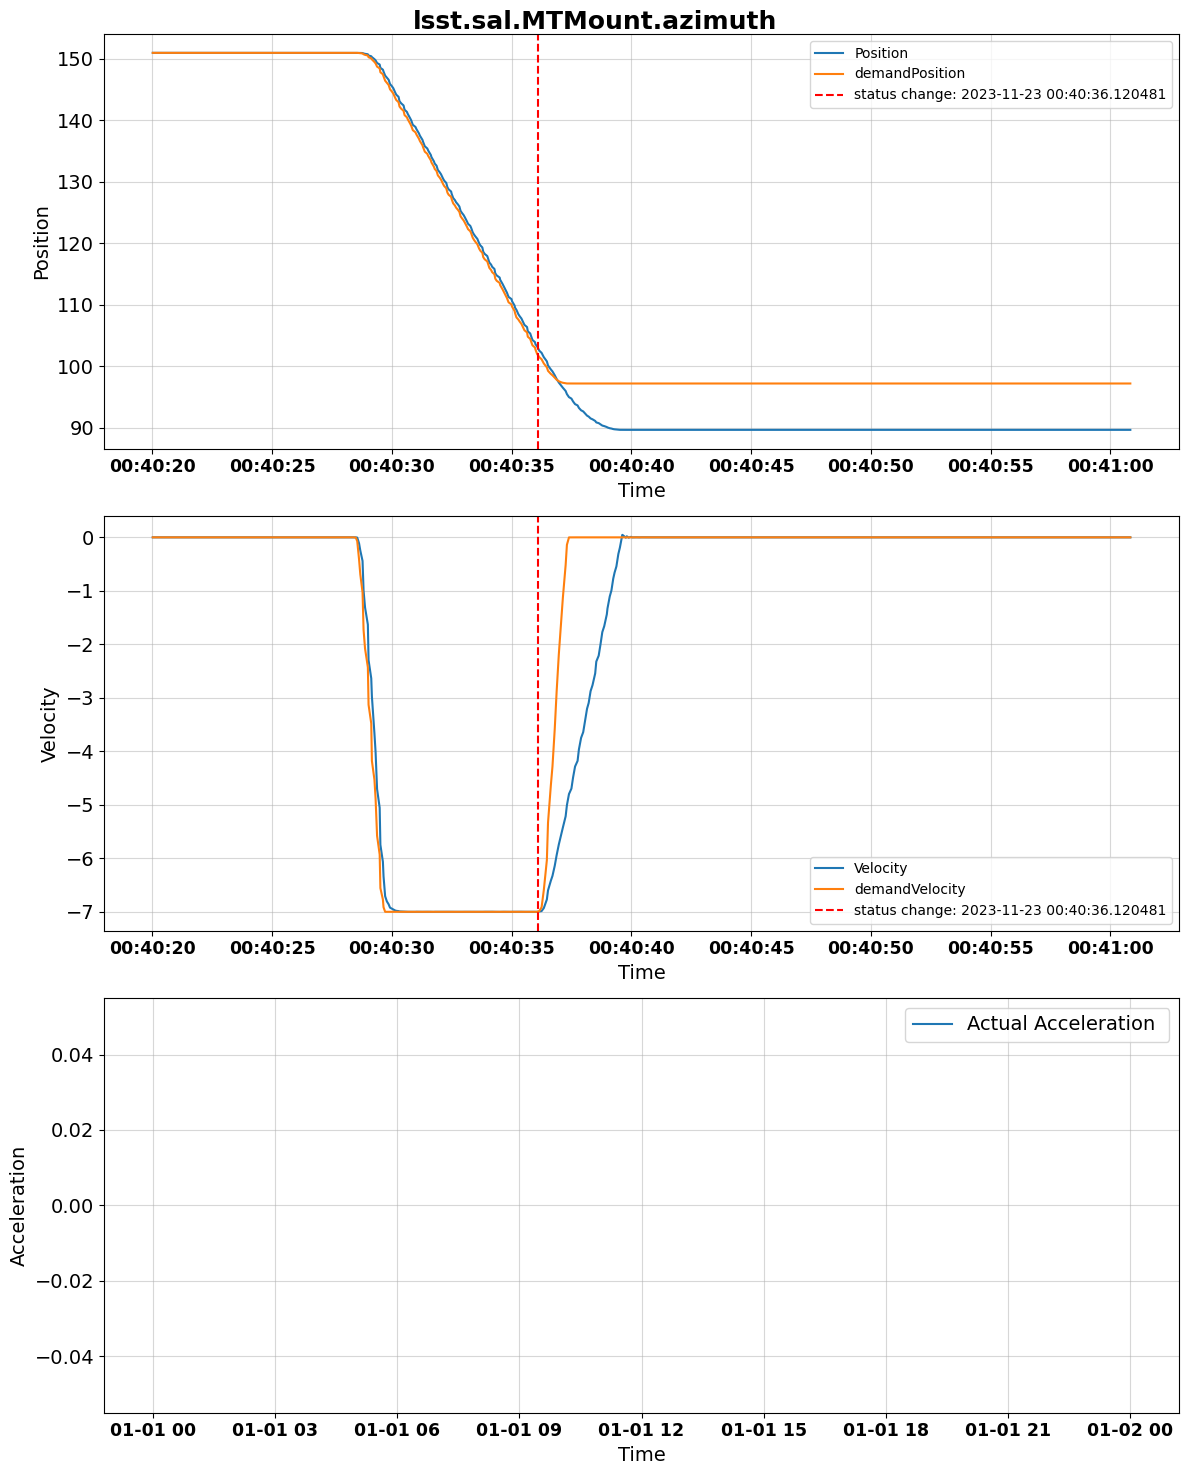

In [20]:
##################################################
plot_az(df_az, event1)
##################################################

### ZOOM

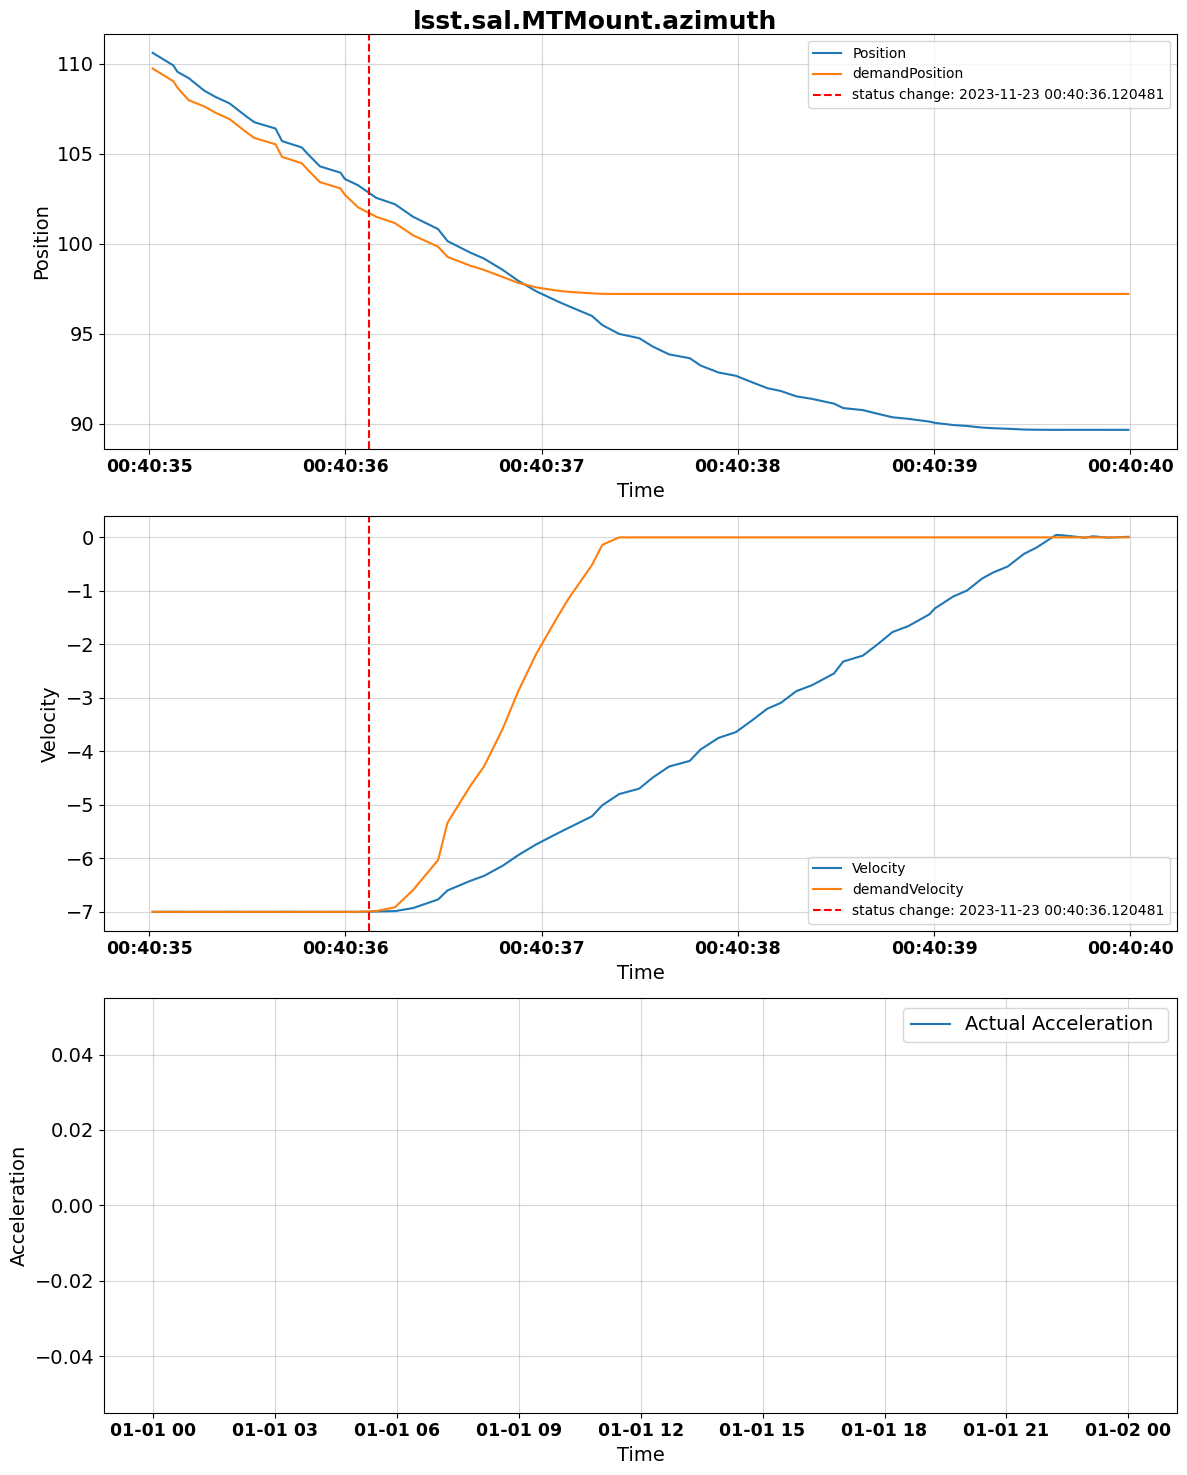

In [21]:
##################################################
time_start = "2023-11-23T00:40:35"
time_ends = "2023-11-23T00:40:40"
##################################################
start, end = format_time(time_start, time_ends)
df_az = call_az_data_range(start, end)
##################################################
plot_az(df_az, event1)

# Az Stopping distance calculation
### a). Last position after fully stopping

In [27]:
# Last azimuth position:
last_aPos = df_az["actualPosition"].iloc[-1]  # --> 89.672343
print("Last azimuth position: ", "%.3f" % last_aPos, " [deg]")

Last azimuth position:  89.672  [deg]


### b) The event time determined above: 
value_to_find = "2023-11-23 00:40:36.120481+00:00"

* value when velocity start changing.

In [25]:
df_az.index[30:50]

DatetimeIndex(['2023-11-23 00:40:37.309580+00:00',
               '2023-11-23 00:40:37.395419+00:00',
               '2023-11-23 00:40:37.497737+00:00',
               '2023-11-23 00:40:37.565769+00:00',
               '2023-11-23 00:40:37.649616+00:00',
               '2023-11-23 00:40:37.754980+00:00',
               '2023-11-23 00:40:37.810047+00:00',
               '2023-11-23 00:40:37.901343+00:00',
               '2023-11-23 00:40:37.990183+00:00',
               '2023-11-23 00:40:38.071257+00:00',
               '2023-11-23 00:40:38.149815+00:00',
               '2023-11-23 00:40:38.218290+00:00',
               '2023-11-23 00:40:38.298128+00:00',
               '2023-11-23 00:40:38.378286+00:00',
               '2023-11-23 00:40:38.490335+00:00',
               '2023-11-23 00:40:38.536467+00:00',
               '2023-11-23 00:40:38.636454+00:00',
               '2023-11-23 00:40:38.714959+00:00',
               '2023-11-23 00:40:38.787575+00:00',
               '2023-11-23 00:4

In [28]:
df_az["timestamp"] = df_az.index  # Establecer la columna 'timestamp' como índice

# Convertir timestamps a strings
df_az["timestamp"] = df_az["timestamp"].astype(str)

# Valor a buscar
search_value = "2023-11-23 00:40:36.157645+00:00" ### put the timestamp found above

# Buscar en la columna 'timestamp' como string
matching_rows = df_az[df_az["timestamp"] == search_value]

if not matching_rows.empty:
    print(f"Rows corresponding to the timestamp '{search_value}':")
    print(matching_rows)
    first_aPos = matching_rows["actualPosition"]
else:
    print(f"Timestamp '{search_value}' not found in the column.")

aPos = first_aPos - last_aPos
print()
print("aPos = first_azPos - last_azPos")
print(" > Difference on azimuth positions: ", aPos, " [deg]")

Rows corresponding to the timestamp '2023-11-23 00:40:36.157645+00:00':
                                  actualPosition  actualVelocity  \
2023-11-23 00:40:36.157645+00:00      102.546129       -6.993879   

                                 actualAcceleration  demandPosition  \
2023-11-23 00:40:36.157645+00:00               None      101.496587   

                                  demandVelocity  \
2023-11-23 00:40:36.157645+00:00        -6.98614   

                                                         timestamp  
2023-11-23 00:40:36.157645+00:00  2023-11-23 00:40:36.157645+00:00  

aPos = first_azPos - last_azPos
 > Difference on azimuth positions:  2023-11-23 00:40:36.157645+00:00    12.873785
Name: actualPosition, dtype: float64  [deg]


## Elevation Brake Test

In [41]:
##################################################
time_start = "2024-12-08T09:02:22"
time_ends = "2024-12-08T09:02:50"
##################################################
start, end = format_time(time_start, time_ends)
df_el = call_el_data_range(start, end)
event2 = get_event(start, end)
##################################################


MTMount_logevent_azimuthSystemState (op-1): 
                                  motionControllerState0  \
2024-12-08 09:02:22.303270+00:00                       2   
2024-12-08 09:02:42.799710+00:00                       2   
2024-12-08 09:02:43.142011+00:00                       2   

                                  motionControllerState5  \
2024-12-08 09:02:22.303270+00:00                       2   
2024-12-08 09:02:42.799710+00:00                       2   
2024-12-08 09:02:43.142011+00:00                       2   

                                  motionControllerState10  
2024-12-08 09:02:22.303270+00:00                        2  
2024-12-08 09:02:42.799710+00:00                        2  
2024-12-08 09:02:43.142011+00:00                        2  

MTMount.logevent_azimuthMotionState (op-2): 
Empty DataFrame
Columns: []
Index: []

MTMount.logevent_elevationMotionState (op-3): 
Empty DataFrame
Columns: []
Index: []



Please enter your option:  1


You have entered: 1
You selected azimuthSystemState
                                 time  motionControllerState0  \
Axis                                                            
0    2024-12-08 09:02:22.303270+00:00                       2   
1    2024-12-08 09:02:42.799710+00:00                       2   
2    2024-12-08 09:02:43.142011+00:00                       2   

      motionControllerState5  motionControllerState10  
Axis                                                   
0                          2                        2  
1                          2                        2  
2                          2                        2  

Event happened at:  2024-12-08T09:02:22.303270



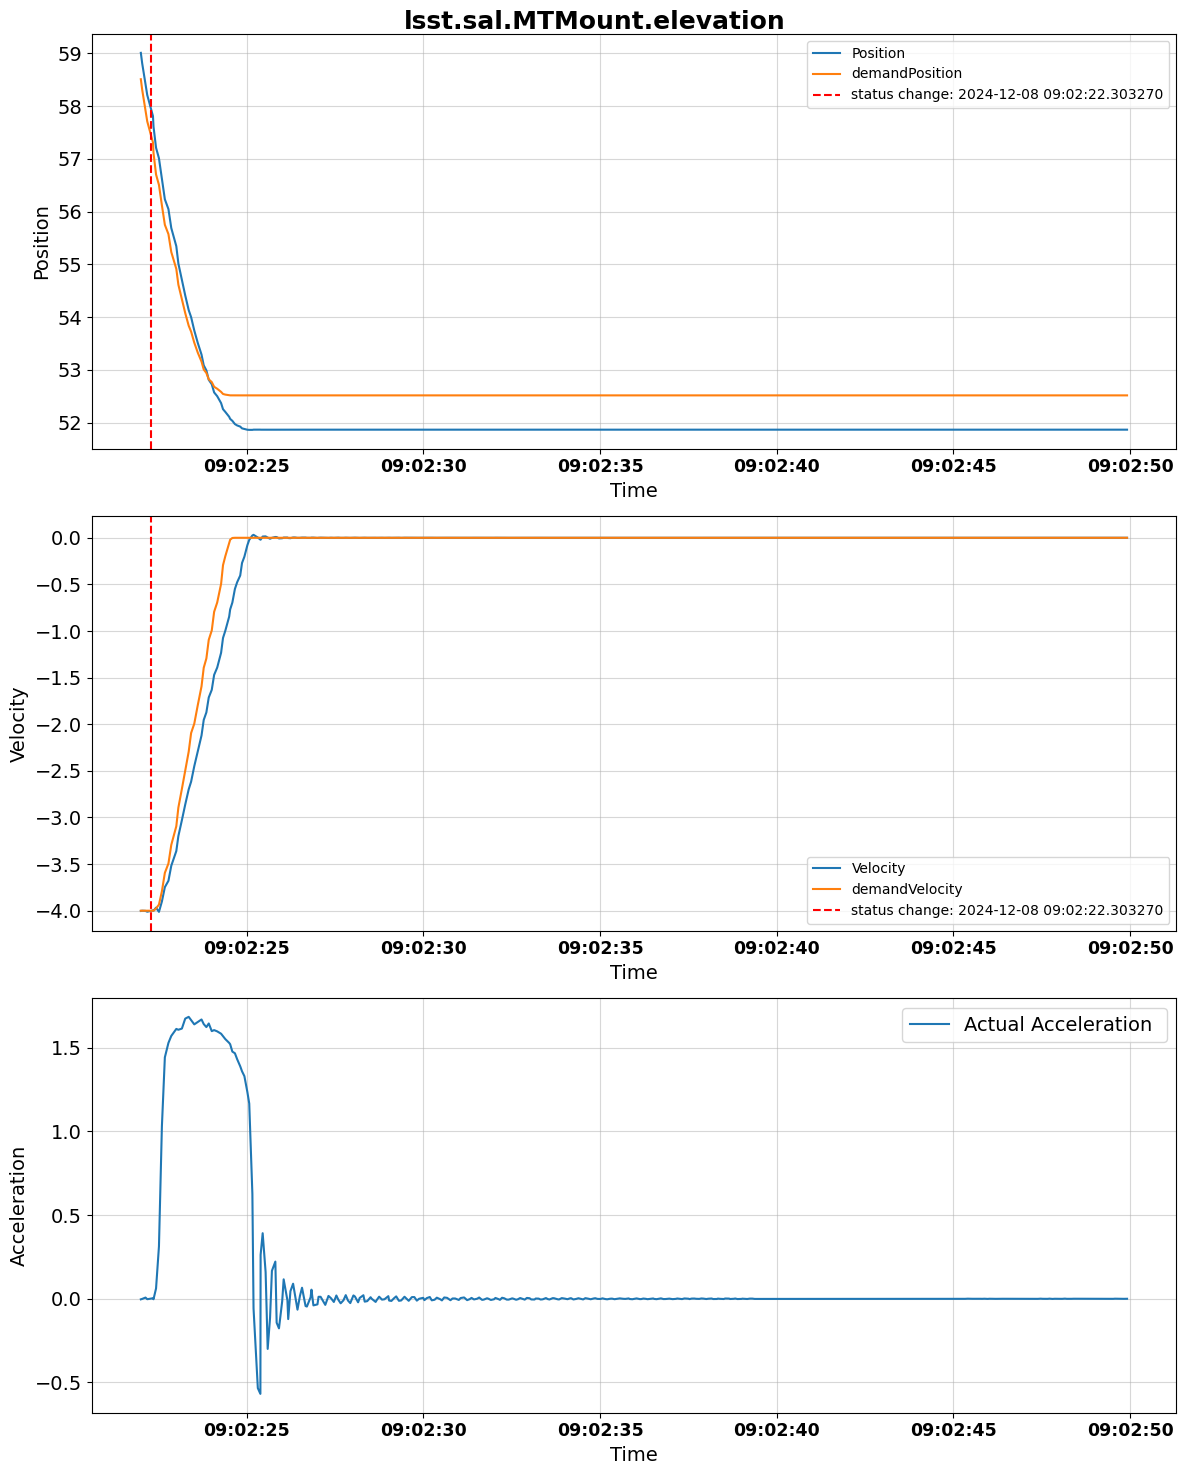

In [40]:
##################################################
time_start = "2024-12-08T09:02:22"
time_ends = "2024-12-08T09:02:50"
##################################################
start, end = format_time(time_start, time_ends)
df_el = call_el_data_range(start, end)
##################################################
plot_el(df_el, event2)
##################################################

# El Stopping distance calculation
### a). Last position after fully stopping

In [42]:
# Last elevation position:
last_ePos = df_el["actualPosition"].iloc[-1] 
print("Last elevation position: ", "%.3f" % last_ePos, " [deg]")

Last elevation position:  51.866  [deg]


### b) The event2 time determined above: 
value_to_find = "2024-12-08T09:02:22.303270"

* value when velocity start changing.

In [44]:
df_el.index[:30]

DatetimeIndex(['2024-12-08 09:02:22.005091+00:00',
               '2024-12-08 09:02:22.043519+00:00',
               '2024-12-08 09:02:22.137451+00:00',
               '2024-12-08 09:02:22.186460+00:00',
               '2024-12-08 09:02:22.348301+00:00',
               '2024-12-08 09:02:22.363952+00:00',
               '2024-12-08 09:02:22.435547+00:00',
               '2024-12-08 09:02:22.517741+00:00',
               '2024-12-08 09:02:22.601132+00:00',
               '2024-12-08 09:02:22.684857+00:00',
               '2024-12-08 09:02:22.786062+00:00',
               '2024-12-08 09:02:22.866732+00:00',
               '2024-12-08 09:02:23.008799+00:00',
               '2024-12-08 09:02:23.067263+00:00',
               '2024-12-08 09:02:23.166654+00:00',
               '2024-12-08 09:02:23.261565+00:00',
               '2024-12-08 09:02:23.359552+00:00',
               '2024-12-08 09:02:23.428021+00:00',
               '2024-12-08 09:02:23.517490+00:00',
               '2024-12-08 09:0

In [45]:
df_el["timestamp"] = df_el.index  # Establecer la columna 'timestamp' como índice

# Convertir timestamps a strings
df_el["timestamp"] = df_el["timestamp"].astype(str)

# Valor a buscar
search_value = "2024-12-08 09:02:22.348301+00:00" ### put the timestamp found above

# Buscar en la columna 'timestamp' como string
matching_rows = df_el[df_el["timestamp"] == search_value]

if not matching_rows.empty:
    print(f"Rows corresponding to the timestamp '{search_value}':")
    print(matching_rows)
    first_ePos = matching_rows["actualPosition"]
else:
    print(f"Timestamp '{search_value}' not found in the column.")

ePos = first_ePos - last_ePos
print()
print("ePos = first_ePos - last_ezPos")
print(" > Difference on elevation positions: ", ePos, " [deg]")

Rows corresponding to the timestamp '2024-12-08 09:02:22.348301+00:00':
                                  actualPosition  actualVelocity  \
2024-12-08 09:02:22.348301+00:00       57.811508       -3.996361   

                                  actualAcceleration  demandPosition  \
2024-12-08 09:02:22.348301+00:00            0.003234       57.311492   

                                  demandVelocity  \
2024-12-08 09:02:22.348301+00:00            -4.0   

                                                         timestamp  
2024-12-08 09:02:22.348301+00:00  2024-12-08 09:02:22.348301+00:00  

ePos = first_ePos - last_ezPos
 > Difference on elevation positions:  2024-12-08 09:02:22.348301+00:00    5.945206
Name: actualPosition, dtype: float64  [deg]


# F(t) Delta Time

In [27]:
#################################
def delta_time(timestamp1, timestamp2):
    # Convert to datetime objects
    dt1 = datetime.fromisoformat(timestamp1)
    dt2 = datetime.fromisoformat(timestamp2)

    # Calculate time difference
    diff = dt2 - dt1
    print(f"Time difference: {diff}")
    return diff
#################################

In [28]:
# data from motionControllerState10
timestamp1 = "2023-11-23 00:40:36.120481+00:00"

# Data from "find_first_non_zero_from_end"
timestamp2 = "2023-11-23 00:40:39.990298+00:00"

delta_time(timestamp1, timestamp2)

Time difference: 0:00:03.869817


datetime.timedelta(seconds=3, microseconds=869817)

#### Time difference: 0:00:03.869817